Final Tutorial

In [3]:
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import spotipy
import numpy as np

Use xml files to scrape from spotify charts
for each track show their streams per day, maybe as an array or another dataframe
from there spotipy api can be used to observe the details of these songs

In [4]:
# Collect links from spotify charts top 200 streams per day
ref_str = "https://spotifycharts.com/regional/global/daily/"
ref_arr = []

# gets every day from janurary 2017 to October 2020

# for year in range(2017, 2021):
for year in range(2017, 2018):
    date = ""
    
    endingMonth = 12
    if year == 2020:
        endingMonth = 10
        
    # for month in range (1, endingMonth + 1):
    for month in range (1,2):
       
        dayCount = -1

        #gets proper day count per month
        thirtyDayCountMonths = [4, 6, 9, 11]
        if month == 2:
            dayCount = 29
        elif month in thirtyDayCountMonths:
            dayCount = 30
        else:
            dayCount = 31

        if int(month) < 10:
            month = "0" + str(month)
        for day in range (1, dayCount + 1):
           
            if int(day) < 10:
                day = "0" + str(day)

            date = str(year) + "-" + str(month) + "-" + str(day) + "/download"
            date = ref_str + date
            ref_arr.append(date)

ref_arr

['https://spotifycharts.com/regional/global/daily/2017-01-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-02/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-03/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-04/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-05/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-06/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-07/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-08/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-09/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-10/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-11/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-12/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-13/download',
 'https://spotifycharts.com/regional/global/daily/2017-01-14/dow

In [6]:
#Loop downloading and appending of dataframes 

df = pd.DataFrame(columns =['position', 'track_name', 'artist', 'streams', 'url', 'date'] )

#make dir to save to
path = "sheets"
folder_exists = False
try:
    os.mkdir(path)
except OSError:
    print ("Folder already exists")
    folder_exists = True

# if not folder_exists:
for i in ref_arr:
    r = requests.get(i, allow_redirects = True)
    #String manipulation to read from the correct csv files
    date = i[48:58]
    print(date)
    fileName = "regional-global-daily-" + date + ".csv"
    print(fileName)
    open(fileName, "wb").write(r.content)

    os.rename(fileName, "sheets/" + fileName)

    df_new = pd.read_csv(path + "/" + fileName)
    df_new.columns= ['position', 'track_name', 'artist', 'streams', 'url']
    df_new['date'] = date
    
    df_new = df_new.iloc[1:] #deletes junk row from csv conversion
    df = df.append(df_new)



df.drop(['position'], axis=1, inplace=True) #delete position row since rank alraedy has this information

df.drop(df.index[[4000,6000]], inplace = True)

Folder already exists


IndexError: index 4000 is out of bounds for axis 0 with size 0

In [11]:
df

,track_name,artist,streams,url,date
1,Starboy,The Weeknd,3135625,https://open.spotify.com/track/5aAx2yezTd8zXrk...,2017-01-01
2,Closer,The Chainsmokers,3015525,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,2017-01-01
3,Let Me Love You,DJ Snake,2545384,https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,2017-01-01
4,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,2356604,https://open.spotify.com/track/5knuzwU65gJK7IF...,2017-01-01
5,One Dance,Drake,2259887,https://open.spotify.com/track/1xznGGDReH1oQq0...,2017-01-01
...,...,...,...,...,...
196,Take Me To Church,Hozier,394695,https://open.spotify.com/track/0IqKeD8ZSP72KbG...,2017-01-31
197,"Someone In The Crowd - From ""La La Land"" Sound...",Emma Stone,392060,https://open.spotify.com/track/7xE4vKvjqUTtHyJ...,2017-01-31
198,Too Many Years,Kodak Black,390969,https://open.spotify.com/track/0BU7nIcCZxYSE0h...,2017-01-31
199,Ain't My Fault,Zara Larsson,389791,https://open.spotify.com/track/0ADG9OgdVTL7fgR...,2017-01-31


In [5]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials


SPOTIPY_CLIENT_ID="ea1a162fbc6f413990542b76ab82a168"
SPOTIPY_CLIENT_SECRET="a09882042ce54f158fdd2b6baaf2b26d"
SPOTIPY_CLIENT_REDIRECT="http://www.cs.umd.edu/class/fall2020/cmsc320-0201/"

scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET, redirect_uri=SPOTIPY_CLIENT_REDIRECT))

results = sp.current_user_saved_tracks()

# How to get audio features of a track from our data frame

trackName = df.iloc[0].at['track_name']
trackNameWithoutSpaces = '+'.join(trackName.split())
print(trackNameWithoutSpaces)
trackItem = sp.search(trackNameWithoutSpaces, 1, 0)
audiofeatures = sp.audio_features(trackItem['tracks']['items'][0]['id'])
audiofeatures

Starboy


[{'danceability': 0.679,
  'energy': 0.587,
  'key': 7,
  'loudness': -7.015,
  'mode': 1,
  'speechiness': 0.276,
  'acousticness': 0.141,
  'instrumentalness': 6.35e-06,
  'liveness': 0.137,
  'valence': 0.486,
  'tempo': 186.003,
  'type': 'audio_features',
  'id': '7MXVkk9YMctZqd1Srtv4MB',
  'uri': 'spotify:track:7MXVkk9YMctZqd1Srtv4MB',
  'track_href': 'https://api.spotify.com/v1/tracks/7MXVkk9YMctZqd1Srtv4MB',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7MXVkk9YMctZqd1Srtv4MB',
  'duration_ms': 230453,
  'time_signature': 4}]

In [15]:
#adding genre to datarame
#trackArtist = df.iloc[0].at['artist']
#trackArtistWithoutSpaces = '+'.join(trackArtist.split())
#print(trackArtistWithoutSpaces)
#result = sp.search(trackArtistWithoutSpaces)
#track = result['tracks']['items'][0]
#artist = sp.artist(track["artists"][0]["external_urls"]["spotify"])
#print("artist genres:", artist["genres"])

The+Weeknd
artist genres: ['canadian contemporary r&b', 'canadian pop', 'pop']


In [21]:
artist_genres = []

for index, row in df.iterrows():
    artist = row['artist']
    print(index)
    print(artist)
    trackArtistWithoutSpaces = '+'.join(artist.split())
    result = sp.search(trackArtistWithoutSpaces)
    track = result['tracks']['items'][0]
    artist = sp.artist(track["artists"][0]["external_urls"]["spotify"])
    artist_genres.append(artist["genres"])
    print(artist["genres"])


The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
DJ Snake
['dance pop', 'edm', 'electro house', 'electronic trap', 'pop', 'pop dance', 'pop rap']
Clean Bandit
['dance pop', 'edm', 'pop', 'pop dance', 'post-teen pop', 'tropical house', 'uk dance', 'uk funky']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Bruno Mars
['dance pop', 'pop']
Maroon 5
['pop', 'pop rock']
Rae Sremmurd
['hip hop', 'melodic rap', 'mississippi hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Shakira
['colombian pop', 'dance pop', 'latin', 'latin pop', 'pop']
ZAYN
['dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'uk pop']
James Arthur
['pop', 'talent show', 'uk pop']
Migos
['cali rap', 'pop rap', 'rap

['contemporary country', 'country', 'country dawn', 'country road']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Ed Sheeran
['pop', 'uk pop']
ZAYN
['dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'uk pop']
Foster The People
['indie pop', 'indietronica', 'modern alternative rock', 'modern rock', 'rock']
Justin Bieber
['canadian pop', 'pop', 'post-teen pop']
Zara Larsson
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'scandipop', 'swedish electropop', 'swedish pop', 'tropical house']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Childish Gambino
['atl hip hop', 'hip hop', 'pop rap', 'rap']
Galantis
['big room', 'dance pop', 'edm', 'electro house', 'pop', 'pop dance', 'tropical house']
Pharrell Williams
['latin', 'reggaeton', 'reggaeton colombiano']
Adele
['british soul', 'pop',

['big room', 'edm', 'electro house', 'gaming edm', 'pop dance', 'pop edm', 'progressive electro house', 'tropical house']
Alan Walker
['electro house']
CNCO
['boy band', 'latin', 'latin pop', 'reggaeton', 'tropical']
Charlie Puth
['hip hop', 'pittsburgh rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
Robin Schulz
['dance pop', 'edm', 'pop dance', 'tropical house']
Mike Posner
['dance pop', 'edm', 'pop', 'pop dance', 'pop rap']
Alok
['electro house', 'pop nacional']
J Balvin
['latin', 'reggaeton', 'reggaeton colombiano']
Shelley FKA DRAM
['pop rap', 'rap', 'trap', 'virginia hip hop']
Fifth Harmony
['dance pop', 'electropop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show']
Calvin Harris
['dance pop', 'pop', 'pop rap', 'rap']
Aminé
['hip hop', 'pop rap', 'portland hip hop', 'rap', 'underground hip hop']
Alessia Cara
['canadian contemporary r&b', 'canadian pop', 'dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop']
Ricky Martin
['dance pop', 'latin', 'latin 

['canadian contemporary r&b', 'canadian pop', 'pop']
Little Mix
['dance pop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show', 'uk pop']
MiC LOWRY
[]
Joel Adams
['australian pop', 'pop soul']
Bruno Mars
['dance pop', 'pop']
Eminem
['detroit hip hop', 'hip hop', 'rap']
Rae Sremmurd
['hip hop', 'melodic rap', 'mississippi hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Tove Lo
['dance pop', 'electropop', 'metropopolis', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'swedish electropop', 'swedish pop', 'swedish synthpop', 'tropical house']
JP Cooper
['acoustic pop', 'indie cafe pop', 'indiecoustica', 'neo mellow', 'neo-singer-songwriter', 'pop', 'pop rock', 'uk pop', 'viral pop']
Kiiara
['dance pop', 'electropop', 'indie poptimism', 'pop', 'pop dance', 'post-teen pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Coldplay
['permanent wave', 'pop']
Maluma
['reggaeton', 'r

['baton rouge rap', 'trap']
Coldplay
['permanent wave', 'pop']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Mike Perry
['big room', 'dance pop', 'deep tropical house', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'swedish tropical house', 'tropical house']
21 Savage
['atl hip hop', 'rap', 'trap']
Little Mix
['dance pop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show', 'uk pop']
Rob $tone
['san diego rap']
Jon Bellion
['pop rap']
MC G15
['funk carioca', 'funk ostentacao', 'funk paulista']
Rihanna
['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary']
Ariana Grande
['pop', 'post-teen pop']
Sebastian Yatra
['colombian pop', 'latin', 'latin pop', 'reggaeton', 'reggaeton colombiano', 'trap latino']
DNCE
['dance pop', 'pop', 'pop dance', 'pop rock', 'post-teen pop']
Ed Sheeran
['pop', 'uk pop']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop d

['latin', 'latin hip hop', 'reggaeton', 'trap latino', 'tropical']
Adele
['british soul', 'pop', 'pop soul', 'uk pop']
Flo Rida
['dance pop', 'miami hip hop', 'pop', 'pop dance', 'pop rap']
Eminem
['detroit hip hop', 'hip hop', 'rap']
Coldplay
['permanent wave', 'pop']
Post Malone
['dfw rap', 'melodic rap', 'rap']
Coldplay
['permanent wave', 'pop']
The Killers
['modern rock', 'permanent wave', 'rock']
Sam Smith
['dance pop', 'pop', 'post-teen pop', 'uk pop']
Travis Scott
['rap']
Selena Gomez
['dance pop', 'pop', 'pop dance', 'post-teen pop']
Robin Schulz
['dance pop', 'edm', 'pop dance', 'tropical house']
Bryson Tiller
['kentucky hip hop', 'pop', 'pop rap', 'rap', 'trap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Clean Bandit
['dance pop', 'edm', 'pop', 'pop dance', 'post-teen pop', 'tropical house', 'uk dance', 'uk funky']
ZAYN
['dance pop', 'electropop', 'pop', 'pop dance',

['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
Kungs
['edm', 'new french touch', 'pop dance', 'tropical house']
IAmChino
['cubaton', 'reggaeton']
Ozuna
['latin', 'puerto rican pop', 'reggaeton', 'trap latino']
Calum Scott
['neo mellow', 'pop', 'viral pop']
Daddy Yankee
['latin', 'panamanian pop', 'reggaeton', 'trap latino']
Nause
['alternative emo', 'anti-folk', 'bubblegrunge', 'folk punk', 'indie punk', 'indie rock', 'modern power pop', 'modern rock']
Galantis
['big room', 'dance pop', 'edm', 'electro house', 'pop', 'pop dance', 'tropical house']
G-Eazy
['hip hop', 'indie pop rap', 'oakland hip hop', 'pop rap', 'rap']
Enrique Iglesias
['latin', 'reggaeton', 'reggaeton flow', 'trap latino']
G-Eazy
['hip hop', 'indie pop rap', 'oakland hip hop', 'pop rap', 'rap']
Cheat Codes
['meme rap', 'sad rap']
Young M.A
['lgbtq+ hip hop', 'nyc rap', 'pop rap', 'rap', 'trap']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
San Ho

['dance pop', 'pop', 'pop dance', 'post-teen pop']
Calvin Harris
['dance pop', 'pop', 'pop rap', 'rap']
Twenty One Pilots
['modern rock', 'rock']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
Alessia Cara
['canadian contemporary r&b', 'canadian pop', 'dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop']
The Vamps
['boy band', 'dance pop', 'pop', 'post-teen pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Zara Larsson
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'scandipop', 'swedish electropop', 'swedish pop', 'tropical house']
John Legend
['neo mellow', 'neo soul', 'pop', 'pop soul', 'r&b', 'urban contemporary']
Robin Schulz
['dance pop', 'edm', 'pop dance', 'tropical house']
Sage The Gemini
['dance pop', 'hyphy', 'pop rap', 'rap', 'southern hip hop', 'trap']
Alok
['electro house', 'pop nacional']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'u

['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'scandipop', 'swedish electropop', 'swedish pop', 'tropical house']
JP Cooper
['acoustic pop', 'indie cafe pop', 'indiecoustica', 'neo mellow', 'neo-singer-songwriter', 'pop', 'pop rock', 'uk pop', 'viral pop']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
KREAM
['australian hip hop', 'dance pop', 'hip pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Rae Sremmurd
['hip hop', 'melodic rap', 'mississippi hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Justin Bieber
['canadian pop', 'pop', 'post-teen pop']
Chino & Nacho
['electro latino', 'latin', 'latin hip hop', 'latin pop', 'trap latino', 'tropical']
Maluma
['reggaeton', 'reggaeton colombiano']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
James Bay
['modern rock', 'neo mellow', 'pop', 'pop rock']
Little Mix
['dance pop', 'girl 

['dance pop', 'danish electronic', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'tropical house']
NEIKED
['scandipop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Ed Sheeran
['pop', 'uk pop']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Rag'n'Bone Man
['neo soul']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
Noah Cyrus
['dance pop', 'pop', 'post-teen pop']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Twenty One Pilots
['modern rock', 'rock']
Adele
['british soul', 'pop', 'pop soul', 'uk pop']
Fifth Harmony
['dance pop', 'electropop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show']
Snakehips
['edm', 'electropop', 'indie poptimism', 'pop', 'pop dance', 'tropical house']
Jon Bellion
['pop rap']
Twenty One Pilots
['modern rock', 'rock']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
gnash
['ele

['australian hip hop', 'dance pop', 'hip pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Tove Lo
['dance pop', 'electropop', 'metropopolis', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'swedish electropop', 'swedish pop', 'swedish synthpop', 'tropical house']
Future
['atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Future
['atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Isaiah Firebrace
['australian pop', 'australian talent show']
Kiiara
['dance pop', 'electropop', 'indie poptimism', 'pop', 'pop dance', 'post-teen pop']
Mura Masa
['channel islands indie', 'edm', 'vapor soul']
Charly Black
['dancehall']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Marc E. Bassy
['electropop', 'indie pop rap', 'pop', 'pop rap']
Joel Adams
['australian pop', 'pop soul']
Lady Gaga
['dance pop', 'pop', 'pop dance']
Dav

['electropop', 'indie electropop', 'indie poptimism', 'la pop', 'pop dance', 'pop edm', 'tropical house']
DNCE
['dance pop', 'pop', 'pop dance', 'pop rock', 'post-teen pop']
21 Savage
['atl hip hop', 'rap', 'trap']
Daddy Yankee
['latin', 'panamanian pop', 'reggaeton', 'trap latino']
Ozuna
['latin', 'puerto rican pop', 'reggaeton', 'trap latino']
Lukas Graham
['danish pop', 'pop', 'scandipop']
Hearts & Colors
['post-teen pop', 'viral pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
IAmChino
['cubaton', 'reggaeton']
Childish Gambino
['atl hip hop', 'hip hop', 'pop rap', 'rap']
Kungs
['edm', 'new french touch', 'pop dance', 'tropical house']
KYLE
['pop rap', 'rap']
Andy Grammer
['dance pop', 'modern rock', 'neo mellow', 'pop', 'pop rock', 'post-teen pop']
Ariana Grande
['pop', 'post-teen pop']
DJ Snake
['dance pop', 'edm', 'electro house', 'electronic trap', 'pop', 'pop dance', 'pop rap']
Sean Paul
['dance pop', 'dancehall', 'pop dance', 'pop rap']
AJR
['modern rock']

['colombian pop', 'dance pop', 'latin', 'latin pop', 'pop']
Migos
['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
Steve Aoki
['k-pop', 'k-pop boy group']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Martin Garrix
['big room', 'dance pop', 'edm', 'electro house', 'pop', 'pop dance', 'progressive house', 'tropical house']
Machine Gun Kelly
['ohio hip hop', 'pop rap']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
Ariana Grande
['pop', 'post-teen pop']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Hailee Steinfeld
['dance pop', 'pop', 'pop dance', 'post-teen pop']
Calvin Harris
['dance pop', 'pop', 'pop rap', 'rap']
Twenty One Pilots
['modern rock', 'rock']
The Vamps
['boy band', 'dance pop', 'pop', 'post-teen pop']
Alessia Cara
['canadian contemporary r&b', 'canadian

['british soul', 'pop', 'pop soul', 'uk pop']
Rae Sremmurd
['hip hop', 'melodic rap', 'mississippi hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Cheat Codes
['meme rap', 'sad rap']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
San Holo
['edm', 'electro house', 'electronic trap', 'electropop', 'future bass', 'pop dance', 'pop edm', 'vapor twitch']
Ed Sheeran
['pop', 'uk pop']
State of Sound
['deep tropical house', 'swedish tropical house', 'tropical house']
Isaiah Firebrace
['australian pop', 'australian talent show']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Maluma
['reggaeton', 'reggaeton colombiano']
JP Cooper
['acoustic pop', 'indie cafe pop', 'indiecoustica', 'neo mellow', 'neo-singer-songwriter', 'pop', 'pop rock', 'uk pop', 'viral pop']
Zara Larsson
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'scandipop', 'swedish electropop', 'swedish pop', 'tropical house']
Ja

['dance pop', 'edm', 'pop', 'pop dance', 'pop rap']
Martin Jensen
['dance pop', 'danish electronic', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'tropical house']
Rag'n'Bone Man
['neo soul']
Ed Sheeran
['pop', 'uk pop']
Jon Bellion
['pop rap']
Adele
['british soul', 'pop', 'pop soul', 'uk pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Noah Cyrus
['dance pop', 'pop', 'post-teen pop']
Ricky Martin
['dance pop', 'latin', 'latin pop', 'mexican pop', 'puerto rican pop', 'tropical']
NEIKED
['scandipop']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Zion & Lennox
['latin', 'reggaeton', 'reggaeton colombiano']
Calvin Harris
['dance pop', 'pop', 'pop rap', 'rap']
Luke Christopher
['indie pop rap', 'pop rap']
Petit Biscuit
['new french touch', 'tropical house']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
Twenty One Pilots
['modern rock', 'rock']
gnash
['electropop', 'indie cafe pop', 'pop']
Drake


['reggaeton', 'reggaeton colombiano']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Future
['atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Flume
['eau claire indie', 'indie folk', 'melancholia']
Jax Jones
['dance pop', 'edm', 'electro house', 'house', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'tropical house', 'uk dance']
Future
['atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Milky Chance
['german pop']
Marc E. Bassy
['electropop', 'indie pop rap', 'pop', 'pop rap']
Tove Lo
['dance pop', 'electropop', 'metropopolis', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'swedish electropop', 'swedish pop', 'swedish synthpop', 'tropical house']
Big Sean
['detroit hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Joel Adams
['australian pop', 'pop soul']
Travis Scott
['rap']
Galantis
['big room', 'dance pop', 'edm', 'electro house

['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Rihanna
['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary']
Andy Grammer
['dance pop', 'modern rock', 'neo mellow', 'pop', 'pop rock', 'post-teen pop']
FRENSHIP
['electropop', 'indie electropop', 'indie poptimism', 'la pop', 'pop dance', 'pop edm', 'tropical house']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
Carlos Vives
['champeta', 'colombian pop', 'latin', 'latin pop', 'tropical', 'vallenato']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Lukas Graham
['danish pop', 'pop', 'scandipop']
Niall Horan
['dance pop', 'pop', 'post-teen pop']
Ariana Grande
['pop', 'post-teen pop']
G-Eazy
['hip hop', 'indie pop rap', 'oakland hip hop', 'pop rap', 'rap']
DNCE
['dance pop', 'pop', 'pop dance', 'pop rock', 'post-teen pop']
Nause

['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
DJ Snake
['dance pop', 'edm', 'electro house', 'electronic trap', 'pop', 'pop dance', 'pop rap']
Bruno Mars
['dance pop', 'pop']
Starley
['aussietronica', 'pop dance', 'tropical house']
Shakira
['colombian pop', 'dance pop', 'latin', 'latin pop', 'pop']
Steve Aoki
['k-pop', 'k-pop boy group']
Rae Sremmurd
['hip hop', 'melodic rap', 'mississippi hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Machine Gun Kelly
['ohio hip hop', 'pop rap']
Ariana Grande
['pop', 'post-teen pop']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Martin Garrix
['big room', 'dance pop', 'edm', 'electro house', 'pop', 'pop dance', 'progressive house', 'tropical house']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop danc

['cali rap']
Kungs
['edm', 'new french touch', 'pop dance', 'tropical house']
Isaiah Firebrace
['australian pop', 'australian talent show']
Piso 21
['colombian pop', 'latin', 'latin pop', 'reggaeton', 'reggaeton colombiano', 'trap latino']
Young Thug
['dance pop', 'pop', 'pop rap', 'r&b', 'rap']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
San Holo
['edm', 'electro house', 'electronic trap', 'electropop', 'future bass', 'pop dance', 'pop edm', 'vapor twitch']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
James Hersey
['tropical house']
Ed Sheeran
['pop', 'uk pop']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Wisin
['latin', 'latin hip hop', 'reggaeton', 'reggaeton flow', 'trap latino', 'tropical']
Enrique Iglesias
['latin', 'reggaeton', 'reggaeton flow', 'trap latino']
Sia
['australian dance', 'australian pop', 'dance pop', 'pop', 'pop dance']
G-Eazy
['hip hop', 'indie pop

['pop', 'uk pop']
Charlie Puth
['hip hop', 'pittsburgh rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
Justin Timberlake
['dance pop', 'pop']
Shelley FKA DRAM
['pop rap', 'rap', 'trap', 'virginia hip hop']
Sia
['australian dance', 'australian pop', 'dance pop', 'pop', 'pop dance']
Sia
['australian dance', 'australian pop', 'dance pop', 'pop', 'pop dance']
J Balvin
['latin', 'reggaeton', 'reggaeton colombiano']
Martin Jensen
['dance pop', 'danish electronic', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'tropical house']
Nevada
['big room', 'edm', 'electro house', 'gaming edm', 'pop dance', 'pop edm', 'progressive electro house', 'tropical house']
Jon Bellion
['pop rap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Rag'n'Bone Man
['neo soul']
Noah Cyrus
['dance pop', 'pop', 'post-teen pop']
Mike Posner
['dance pop', 'edm', 'pop', 'pop dance', 'pop rap']
Adele
['british soul', 'pop', 'pop soul', 'uk pop']
Ricky Martin
['dance pop', 'latin', 'latin pop', '

['canadian contemporary r&b', 'canadian pop', 'pop']
Mura Masa
['channel islands indie', 'edm', 'vapor soul']
Future
['atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Future
['atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Big Sean
['detroit hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Flume
['eau claire indie', 'indie folk', 'melancholia']
Dante Klein
['dance pop', 'edm', 'electro house', 'electropop', 'pop', 'pop dance', 'pop edm', 'pop rap', 'post-teen pop', 'tropical house']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Lady Gaga
['dance pop', 'pop', 'pop dance']
Jax Jones
['dance pop', 'edm', 'electro house', 'house', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'tropica

['contemporary country', 'country', 'country dawn', 'country road']
Lil Wayne
['baton rouge rap', 'trap']
AJR
['modern rock']
Justin Bieber
['canadian pop', 'pop', 'post-teen pop']
Hearts & Colors
['post-teen pop', 'viral pop']
Rihanna
['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
21 Savage
['atl hip hop', 'rap', 'trap']
Coldplay
['permanent wave', 'pop']
Bruno Mars
['dance pop', 'pop']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
Mike Perry
['big room', 'dance pop', 'deep tropical house', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'swedish tropical house', 'tropical house']
Sebastian Yatra
['colombian pop', 'latin', 'latin pop', 'reggaeton', 'reggaeton colombiano', 'trap latino']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Childish Gambino
['atl hip hop', 'h

['pop', 'uk pop']
Ed Sheeran
['pop', 'uk pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Clean Bandit
['dance pop', 'edm', 'pop', 'pop dance', 'post-teen pop', 'tropical house', 'uk dance', 'uk funky']
ZAYN
['dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'uk pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Maroon 5
['pop', 'pop rock']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
James Arthur
['pop', 'talent show', 'uk pop']
Migos
['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
DJ Snake
['dance pop', 'edm', 'electro house', 'electronic trap', 'pop', 'pop dance', 'pop rap']
Shakira
['colombian pop', 'dance pop', 'latin', 'latin pop', 'pop']
Starley
['aussietronica', 'pop dance', 'tropical house']
Bru

['edm', 'new french touch', 'pop dance', 'tropical house']
Little Mix
['dance pop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show', 'uk pop']
Piso 21
['colombian pop', 'latin', 'latin pop', 'reggaeton', 'reggaeton colombiano', 'trap latino']
Lil Uzi Vert
['melodic rap', 'philly rap', 'rap', 'trap']
DJ Snake
['dance pop', 'edm', 'electro house', 'electronic trap', 'pop', 'pop dance', 'pop rap']
Flo Rida
['dance pop', 'miami hip hop', 'pop', 'pop dance', 'pop rap']
The xx
['emo rap', 'miami hip hop']
Ariana Grande
['pop', 'post-teen pop']
Calum Scott
['neo mellow', 'pop', 'viral pop']
JP Cooper
['acoustic pop', 'indie cafe pop', 'indiecoustica', 'neo mellow', 'neo-singer-songwriter', 'pop', 'pop rock', 'uk pop', 'viral pop']
Enrique Iglesias
['latin', 'reggaeton', 'reggaeton flow', 'trap latino']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
Rihanna
['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen 

['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
Twenty One Pilots
['modern rock', 'rock']
CNCO
['boy band', 'latin', 'latin pop', 'reggaeton', 'tropical']
Martin Jensen
['dance pop', 'danish electronic', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'tropical house']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
Alan Walker
['electro house']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Aminé
['hip hop', 'pop rap', 'portland hip hop', 'rap', 'underground hip hop']
Big Sean
['detroit hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Jon Bellion
['pop rap']
Justin Timberlake
['dance pop', 'pop']
Shelley FKA DRAM
['pop rap', 'rap', 'trap', 'virginia hip hop']
Charlie Puth
['hip hop', 'pittsburgh rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
J Balvin
['latin', 'reggaeton', 'reggaeton colombiano']
Sia
['australian dance', 'australian pop', 'dance pop', 'pop', 

['detroit hip hop', 'hip hop', 'rap']
Lauv
['electropop', 'pop', 'post-teen pop']
Maluma
['reggaeton', 'reggaeton colombiano']
Stanaj
['dance pop', 'edm', 'pop', 'pop dance', 'pop edm', 'tropical house']
Justin Bieber
['canadian pop', 'pop', 'post-teen pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Bruno Mars
['dance pop', 'pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
ZAYN
['dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'uk pop']
Ed Sheeran
['pop', 'uk pop']
VÉRITÉ
['brooklyn indie', 'electropop', 'indie cafe pop', 'indie electropop', 'indie pop', 'indie poptimism', 'metropopolis', 'nyc pop', 'pop', 'shimmer pop', 'vapor pop', 'vapor soul']
Future
['atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
The xx
['emo rap', 'miami hip hop']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Drake
['canadian hip

['modern rock', 'rock']
gnash
['electropop', 'indie cafe pop', 'pop']
Rob $tone
['san diego rap']
Alan Walker
['electro house']
G-Eazy
['hip hop', 'indie pop rap', 'oakland hip hop', 'pop rap', 'rap']
Desiigner
['pop rap', 'rap', 'trap', 'viral trap']
Fifth Harmony
['dance pop', 'electropop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show']
21 Savage
['atl hip hop', 'rap', 'trap']
Vice
['contemporary country', 'country', 'country dawn', 'country road']
Justin Bieber
['canadian pop', 'pop', 'post-teen pop']
Lil Wayne
['baton rouge rap', 'trap']
Childish Gambino
['atl hip hop', 'hip hop', 'pop rap', 'rap']
Isaiah Firebrace
['australian pop', 'australian talent show']
Bruno Mars
['dance pop', 'pop']
Justin Bieber
['canadian pop', 'pop', 'post-teen pop']
DVBBS
['big room', 'canadian electronic', 'dance pop', 'deep big room', 'edm', 'electro house', 'pop dance', 'pop edm', 'progressive electro house', 'tropical house']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', '

['chicago rap', 'rap']
Sam Smith
['dance pop', 'pop', 'post-teen pop', 'uk pop']
Marc E. Bassy
['electropop', 'indie pop rap', 'pop', 'pop rap']
Galantis
['big room', 'dance pop', 'edm', 'electro house', 'pop', 'pop dance', 'tropical house']
Joel Adams
['australian pop', 'pop soul']
Ed Sheeran
['pop', 'uk pop']
Ed Sheeran
['pop', 'uk pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Ed Sheeran
['pop', 'uk pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
ZAYN
['dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'uk pop']
Clean Bandit
['dance pop', 'edm', 'pop', 'pop dance', 'post-teen pop', 'tropical house', 'uk dance', 'uk funky']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
James Arthur
['pop', 'talent show', 'uk pop']
Maroon 5
['pop', 'pop rock']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Drake
['canadian hip hop', 'canadian pop', 'hip hop',

['acoustic pop', 'indie cafe pop', 'indiecoustica', 'neo mellow', 'neo-singer-songwriter', 'pop', 'pop rock', 'uk pop', 'viral pop']
Niall Horan
['dance pop', 'pop', 'post-teen pop']
Rihanna
['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary']
Flo Rida
['dance pop', 'miami hip hop', 'pop', 'pop dance', 'pop rap']
Lukas Graham
['danish pop', 'pop', 'scandipop']
Wisin
['latin', 'latin hip hop', 'reggaeton', 'reggaeton flow', 'trap latino', 'tropical']
Piso 21
['colombian pop', 'latin', 'latin pop', 'reggaeton', 'reggaeton colombiano', 'trap latino']
DNCE
['dance pop', 'pop', 'pop dance', 'pop rock', 'post-teen pop']
Ariana Grande
['pop', 'post-teen pop']
Calum Scott
['neo mellow', 'pop', 'viral pop']
Little Mix
['dance pop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show', 'uk pop']
Lil Uzi Vert
['melodic rap', 'philly rap', 'rap', 'trap']
DJ Snake
['dance pop', 'edm', 'electro house', 'electronic trap', 'pop', 'pop 

['neo mellow', 'neo soul', 'pop', 'pop soul', 'r&b', 'urban contemporary']
Alessia Cara
['canadian contemporary r&b', 'canadian pop', 'dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop']
Hailee Steinfeld
['dance pop', 'pop', 'pop dance', 'post-teen pop']
Calvin Harris
['dance pop', 'pop', 'pop rap', 'rap']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
Martin Jensen
['dance pop', 'danish electronic', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'tropical house']
Luis Fonsi
['latin', 'latin pop', 'puerto rican pop', 'tropical']
Twenty One Pilots
['modern rock', 'rock']
CNCO
['boy band', 'latin', 'latin pop', 'reggaeton', 'tropical']
Big Sean
['detroit hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Jon Bellion
['pop rap']
Alan Walker
['electro house']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical ho

['detroit hip hop', 'hip hop', 'rap']
James Bay
['modern rock', 'neo mellow', 'pop', 'pop rock']
The xx
['emo rap', 'miami hip hop']
Young Thug
['dance pop', 'pop', 'pop rap', 'r&b', 'rap']
Bruno Mars
['dance pop', 'pop']
Julia Michaels
['canadian contemporary r&b', 'indie cafe pop', 'pop']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
Cheat Codes
['meme rap', 'sad rap']
Zara Larsson
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'scandipop', 'swedish electropop', 'swedish pop', 'tropical house']
Milky Chance
['german pop']
Mura Masa
['channel islands indie', 'edm', 'vapor soul']
Big Sean
['detroit hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Sia
['australian dance', 'australian pop', 'dance pop', 'pop', 'pop dance']
Maluma
['reggaeton', 'reggaeton colombiano']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Lauv
['electropop',

['modern rock', 'rock']
Calvin Harris
['dance pop', 'pop', 'pop rap', 'rap']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
Ed Sheeran
['pop', 'uk pop']
Hearts & Colors
['post-teen pop', 'viral pop']
Twenty One Pilots
['modern rock', 'rock']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Rob $tone
['san diego rap']
Fifth Harmony
['dance pop', 'electropop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show']
21 Savage
['atl hip hop', 'rap', 'trap']
gnash
['electropop', 'indie cafe pop', 'pop']
Cashmere Cat
['dance pop', 'downtempo', 'pop', 'post-teen pop', 'shiver pop']
Alan Walker
['electro house']
Migos
['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
Desiigner
['pop rap', 'rap', 'trap', 'viral trap']
Julia Michaels
['canadian contemporary r&b', 'indie cafe pop', 'pop']
Justin Bieber
['canadian pop'

['dance pop', 'pop', 'pop rap', 'r&b', 'rap']
Lady Gaga
['dance pop', 'pop', 'pop dance']
Farruko
['latin', 'latin hip hop', 'reggaeton', 'trap latino', 'tropical']
The xx
['emo rap', 'miami hip hop']
John Legend
['neo mellow', 'neo soul', 'pop', 'pop soul', 'r&b', 'urban contemporary']
Flume
['eau claire indie', 'indie folk', 'melancholia']
Queen
['electropop', 'pop', 'pop rap']
Post Malone
['dfw rap', 'melodic rap', 'rap']
Young M.A
['lgbtq+ hip hop', 'nyc rap', 'pop rap', 'rap', 'trap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Coldplay
['permanent wave', 'pop']
The Killers
['modern rock', 'permanent wave', 'rock']
Ed Sheeran
['pop', 'uk pop']
Foster The People
['indie pop', 'indietronica', 'modern alternative rock', 'modern rock', 'rock']
Gucci Mane
['emo rap', 'lgbtq+ hip hop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Ed Sheeran
['pop', 'uk pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
E

['edm', 'electro house', 'electronic trap', 'electropop', 'future bass', 'pop dance', 'pop edm', 'vapor twitch']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Carlos Vives
['champeta', 'colombian pop', 'latin', 'latin pop', 'tropical', 'vallenato']
Mike Perry
['big room', 'dance pop', 'deep tropical house', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'swedish tropical house', 'tropical house']
JP Cooper
['acoustic pop', 'indie cafe pop', 'indiecoustica', 'neo mellow', 'neo-singer-songwriter', 'pop', 'pop rock', 'uk pop', 'viral pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
John Mayer
['neo mellow', 'pop', 'pop rock', 'singer-songwriter']
FRENSHIP
['electropop', 'indie electropop', 'indie poptimism', 'la pop', 'pop dance', 'pop edm', 'tropical house']
Rihanna
['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary']
Wisin
['latin', 'latin hip hop', 'reggaeton', '

['canadian contemporary r&b', 'canadian pop', 'dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop']
Martin Garrix
['big room', 'dance pop', 'edm', 'electro house', 'pop', 'pop dance', 'progressive house', 'tropical house']
The Vamps
['boy band', 'dance pop', 'pop', 'post-teen pop']
Alok
['electro house', 'pop nacional']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
Sage The Gemini
['dance pop', 'hyphy', 'pop rap', 'rap', 'southern hip hop', 'trap']
Robin Schulz
['dance pop', 'edm', 'pop dance', 'tropical house']
Calvin Harris
['dance pop', 'pop', 'pop rap', 'rap']
Zara Larsson
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'scandipop', 'swedish electropop', 'swedish pop', 'tropical house']
Martin Jensen
['dance pop', 'danish electronic', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'tropical house']
CNCO
['boy band', 'latin', 'latin pop', 'reggaeton', 'tropical']
Alessia Cara
['canadian contemporary r&b', 'c

['latin', 'reggaeton', 'reggaeton flow', 'trap latino']
Olivia Holt
['post-teen pop', 'social media pop']
Calum Scott
['neo mellow', 'pop', 'viral pop']
Chance the Rapper
['canadian pop', 'pop', 'post-teen pop']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
Bruno Mars
['dance pop', 'pop']
Adele
['british soul', 'pop', 'pop soul', 'uk pop']
Cheat Codes
['meme rap', 'sad rap']
Young Thug
['dance pop', 'pop', 'pop rap', 'r&b', 'rap']
Charly Black
['dancehall']
Stanaj
['dance pop', 'edm', 'pop', 'pop dance', 'pop edm', 'tropical house']
MiC LOWRY
[]
Adele
['british soul', 'pop', 'pop soul', 'uk pop']
G-Eazy
['hip hop', 'indie pop rap', 'oakland hip hop', 'pop rap', 'rap']
Maluma
['reggaeton', 'reggaeton colombiano']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Maluma
['reggaeton', 'reggaeton colombiano']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
John Mayer
[

['indie pop rap', 'pop rap']
Ed Sheeran
['pop', 'uk pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Ricky Martin
['dance pop', 'latin', 'latin pop', 'mexican pop', 'puerto rican pop', 'tropical']
NEIKED
['scandipop']
Bebe Rexha
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Mike Posner
['dance pop', 'edm', 'pop', 'pop dance', 'pop rap']
Sia
['australian dance', 'australian pop', 'dance pop', 'pop', 'pop dance']
Twenty One Pilots
['modern rock', 'rock']
Isaiah Firebrace
['australian pop', 'australian talent show']
Julia Michaels
['canadian contemporary r&b', 'indie cafe pop', 'pop']
Rob $tone
['san diego rap']
Little Mix
['dance pop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show', 'uk pop']
Childish Gambino
['atl hip hop', 'hip hop', 'pop rap', 'rap']
Nevada
['big room', 'edm', 'electro house', 'gaming edm', 'pop dance', 'pop edm', 'progressive electro house', 'tropical house']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop

['alternative metal', 'nu metal', 'rap metal', 'rock', 'sacramento indie']
Farruko
['latin', 'latin hip hop', 'reggaeton', 'trap latino', 'tropical']
Sia
['australian dance', 'australian pop', 'dance pop', 'pop', 'pop dance']
Future
['atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
The xx
['emo rap', 'miami hip hop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Zara Larsson
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'scandipop', 'swedish electropop', 'swedish pop', 'tropical house']
John Legend
['neo mellow', 'neo soul', 'pop', 'pop soul', 'r&b', 'urban contemporary']
Chris Brown
['dance pop', 'pop', 'pop rap', 'r&b', 'rap']
MC G15
['funk carioca', 'funk ostentacao', 'funk paulista']
Eminem
['detroit hip hop', 'hip hop', 'rap']
John Mayer
['neo mellow', 'pop', 'pop rock', 'singer-songwriter']
Lady Gaga
['dance pop', 'pop', 'pop dance']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Ed Sheeran
['pop', 'uk pop']

['latin', 'latin hip hop', 'reggaeton', 'reggaeton flow', 'trap latino', 'tropical']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Andy Grammer
['dance pop', 'modern rock', 'neo mellow', 'pop', 'pop rock', 'post-teen pop']
DVBBS
['big room', 'canadian electronic', 'dance pop', 'deep big room', 'edm', 'electro house', 'pop dance', 'pop edm', 'progressive electro house', 'tropical house']
Sebastian Yatra
['colombian pop', 'latin', 'latin pop', 'reggaeton', 'reggaeton colombiano', 'trap latino']
21 Savage
['atl hip hop', 'rap', 'trap']
Mike Perry
['big room', 'dance pop', 'deep tropical house', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'swedish tropical house', 'tropical house']
Coldplay
['permanent wave', 'pop']
Carlos Vives
['champeta', 'colombian pop', 'latin', 'latin pop', 'tropical', 'vallenato']
Rihanna
['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary']
The Weeknd
['canadia

['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
Rae Sremmurd
['hip hop', 'melodic rap', 'mississippi hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
Martin Garrix
['big room', 'dance pop', 'edm', 'electro house', 'pop', 'pop dance', 'progressive house', 'tropical house']
Alok
['electro house', 'pop nacional']
Sage The Gemini
['dance pop', 'hyphy', 'pop rap', 'rap', 'southern hip hop', 'trap']
Robin Schulz
['dance pop', 'edm', 'pop dance', 'tropical house']
Martin Jensen
['dance pop', 'danish electronic', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'tropical house']
John Legend
['neo mellow', 'neo soul', 'pop', 'pop soul', 'r&b', 'urban contemporary']
Zara Larsson
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'scandipop', 'swedish electropop', 'swedish pop', 'tropical house']
Alessia Cara
['canadian contemporary r&b', 'canadian p

['british soul', 'pop', 'pop soul', 'uk pop']
Daddy Yankee
['latin', 'panamanian pop', 'reggaeton', 'trap latino']
Young Thug
['dance pop', 'pop', 'pop rap', 'r&b', 'rap']
Lauv
['electropop', 'pop', 'post-teen pop']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
KREAM
['australian hip hop', 'dance pop', 'hip pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
Chino & Nacho
['electro latino', 'latin', 'latin hip hop', 'latin pop', 'trap latino', 'tropical']
Ryan Gosling
['hollywood']
Big Sean
['detroit hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Chance the Rapper
['canadian pop', 'pop', 'post-teen pop']
MiC LOWRY
[]
Eminem
['detroit hip hop', 'hip hop', 'rap']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
James Bay
['modern rock', 'neo mellow', 'pop', 'pop rock']
Adele
['british soul', 'pop'

['canadian contemporary r&b', 'canadian pop', 'pop']
Shelley FKA DRAM
['pop rap', 'rap', 'trap', 'virginia hip hop']
Bebe Rexha
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
NEIKED
['scandipop']
Ricky Martin
['dance pop', 'latin', 'latin pop', 'mexican pop', 'puerto rican pop', 'tropical']
Sia
['australian dance', 'australian pop', 'dance pop', 'pop', 'pop dance']
Little Mix
['dance pop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show', 'uk pop']
Mike Posner
['dance pop', 'edm', 'pop', 'pop dance', 'pop rap']
Childish Gambino
['atl hip hop', 'hip hop', 'pop rap', 'rap']
Nevada
['big room', 'edm', 'electro house', 'gaming edm', 'pop dance', 'pop edm', 'progressive electro house', 'tropical house']
Isaiah Firebrace
['australian pop', 'australian talent show']
Migos
['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Sia
['australian dance', 'australian pop', 'dance

['dance pop', 'pop', 'pop rap', 'r&b', 'rap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Lady Gaga
['dance pop', 'pop', 'pop dance']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Maluma
['reggaeton', 'reggaeton colombiano']
Maluma
['reggaeton', 'reggaeton colombiano']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
John Legend
['neo mellow', 'neo soul', 'pop', 'pop soul', 'r&b', 'urban contemporary']
Post Malone
['dfw rap', 'melodic rap', 'rap']
Dante Klein
['dance pop', 'edm', 'electro house', 'electropop', 'pop', 'pop dance', 'pop edm', 'pop rap', 'post-teen pop', 'tropical house']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Ed Sheeran
['pop', 'uk pop']
John Mayer
['neo mellow', 'pop', 'pop rock', 'singer-songwriter']
Sam Smith
['dance pop', 'pop', 'post-teen pop', 'uk pop']
Flume
['eau clair

['colombian pop', 'latin', 'latin pop', 'reggaeton', 'reggaeton colombiano', 'trap latino']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Coldplay
['permanent wave', 'pop']
DVBBS
['big room', 'canadian electronic', 'dance pop', 'deep big room', 'edm', 'electro house', 'pop dance', 'pop edm', 'progressive electro house', 'tropical house']
Sebastian Yatra
['colombian pop', 'latin', 'latin pop', 'reggaeton', 'reggaeton colombiano', 'trap latino']
Ozuna
['latin', 'puerto rican pop', 'reggaeton', 'trap latino']
Carlos Vives
['champeta', 'colombian pop', 'latin', 'latin pop', 'tropical', 'vallenato']
Little Mix
['dance pop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show', 'uk pop']
Flo Rida
['dance pop', 'miami hip hop', 'pop', 'pop dance', 'pop rap']
Andy Grammer
['dance pop', 'modern rock', 'neo mellow', 'pop', 'pop rock', 'post-teen pop']
Mike Perry
['big room', 'dance pop', 'deep tropical house', 'edm', 'electro house', 'pop',

['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
The Vamps
['boy band', 'dance pop', 'pop', 'post-teen pop']
Rae Sremmurd
['hip hop', 'melodic rap', 'mississippi hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Ariana Grande
['pop', 'post-teen pop']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
Martin Garrix
['big room', 'dance pop', 'edm', 'electro house', 'pop', 'pop dance', 'progressive house', 'tropical house']
Alok
['electro house', 'pop nacional']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
Martin Jensen
['dance pop', 'danish electronic', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'tropical house']
Robin Schulz
['dance pop', 'edm', 'pop dance', 'tropical house']
Sage The Gemini
['dance pop', 'hyphy', 'pop rap', 'rap', 'southern hip hop', 'trap']
Major Lazer
['dance pop', 'edm', 'electro house', 'moombahton', 'pop', 'pop dance', 'pop rap']
Martin 

['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary']
DNCE
['dance pop', 'pop', 'pop dance', 'pop rock', 'post-teen pop']
Migos
['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
Lukas Graham
['danish pop', 'pop', 'scandipop']
Kungs
['edm', 'new french touch', 'pop dance', 'tropical house']
Stanaj
['dance pop', 'edm', 'pop', 'pop dance', 'pop edm', 'tropical house']
A R I Z O N A
['edm', 'electropop', 'indie poptimism', 'pop', 'pop dance', 'pop edm', 'tropical house']
MØ
['cali rap']
Bruno Mars
['dance pop', 'pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Lil Uzi Vert
['melodic rap', 'philly rap', 'rap', 'trap']
Niall Horan
['dance pop', 'pop', 'post-teen pop']
Ariana Grande
['pop', 'post-teen pop']
Daddy Yankee
['latin', 'panamanian pop', 'reggaeton', 'trap latino']
DJ Snake
['dance pop', 'edm', 'electro house', 'electronic trap', 'pop', 'pop dance', 'pop rap']
Galantis
['big room', 'dance pop', 'edm'

['latin', 'reggaeton', 'reggaeton colombiano']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Nicky Jam
['latin', 'latin hip hop', 'reggaeton', 'trap latino', 'tropical']
Snakehips
['edm', 'electropop', 'indie poptimism', 'pop', 'pop dance', 'tropical house']
Justin Timberlake
['dance pop', 'pop']
Rag'n'Bone Man
['neo soul']
KYLE
['pop rap', 'rap']
Charlie Puth
['hip hop', 'pittsburgh rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
Petit Biscuit
['new french touch', 'tropical house']
Shelley FKA DRAM
['pop rap', 'rap', 'trap', 'virginia hip hop']
Adele
['british soul', 'pop', 'pop soul', 'uk pop']
Luke Christopher
['indie pop rap', 'pop rap']
Ricky Martin
['dance pop', 'latin', 'latin pop', 'mexican pop', 'puerto rican pop', 'tropical']
NEIKED
['scandipop']
Bebe Rexha
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Noah Cyrus
['dance pop', 'pop', 'post-teen pop']
Little Mix
['dance pop', 'girl group', 'pop', 'pop d

['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
Eminem
['detroit hip hop', 'hip hop', 'rap']
Cheat Codes
['meme rap', 'sad rap']
KREAM
['australian hip hop', 'dance pop', 'hip pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop']
ZAYN
['dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'uk pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Migos
['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
Justin Bieber
['canadian pop', 'pop', 'post-teen pop']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
J. Cole
['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
James Bay
['modern rock', 'neo mellow', 'pop', 'pop rock']
Future
['atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Future
['atl hip hop', 'pop rap', 'r

['conscious hip hop', 'hip hop', 'north carolina hip hop', 'rap']
Desiigner
['pop rap', 'rap', 'trap', 'viral trap']
JP Cooper
['acoustic pop', 'indie cafe pop', 'indiecoustica', 'neo mellow', 'neo-singer-songwriter', 'pop', 'pop rock', 'uk pop', 'viral pop']
Sia
['australian dance', 'australian pop', 'dance pop', 'pop', 'pop dance']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Sean Paul
['dance pop', 'dancehall', 'pop dance', 'pop rap']
Vice
['contemporary country', 'country', 'country dawn', 'country road']
G-Eazy
['hip hop', 'indie pop rap', 'oakland hip hop', 'pop rap', 'rap']
Ozuna
['latin', 'puerto rican pop', 'reggaeton', 'trap latino']
Carlos Vives
['champeta', 'colombian pop', 'latin', 'latin pop', 'tropical', 'vallenato']
Fifth Harmony
['dance pop', 'electropop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show']
Piso 21
['colombian pop', 'latin', 'latin pop', 'reggaeton', 'reggaeton colombiano', 'trap latino']
Justin B

['dance pop', 'edm', 'pop', 'pop dance', 'post-teen pop', 'tropical house', 'uk dance', 'uk funky']
Luis Fonsi
['latin', 'latin pop', 'puerto rican pop', 'tropical']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
James Arthur
['pop', 'talent show', 'uk pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Migos
['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
The Weeknd
['canadian contemporary r&b', 'canadian pop', 'pop']
Maroon 5
['pop', 'pop rock']
Starley
['aussietronica', 'pop dance', 'tropical house']
Shakira
['colombian pop', 'dance pop', 'latin', 'latin pop', 'pop']
Steve Aoki
['k-pop', 'k-pop boy group']
Drake
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap']
Machine Gun Kelly
['ohio hip hop', 'pop rap']
DJ Snake
['dance pop', 'edm', 'electro house', 'electronic trap', 'pop', 'pop dance', 'pop rap']
Bruno Mars
['dance pop', 'pop']
Martin Garrix
['big room', 'dance pop', 'edm', 'e

['edm', 'electropop', 'indie poptimism', 'pop', 'pop dance', 'pop edm', 'tropical house']
Rihanna
['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary']
FRENSHIP
['electropop', 'indie electropop', 'indie poptimism', 'la pop', 'pop dance', 'pop edm', 'tropical house']
Rihanna
['barbadian pop', 'dance pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary']
Post Malone
['dfw rap', 'melodic rap', 'rap']
Coldplay
['permanent wave', 'pop']
Niall Horan
['dance pop', 'pop', 'post-teen pop']
Migos
['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap']
Little Mix
['dance pop', 'girl group', 'pop', 'pop dance', 'post-teen pop', 'talent show', 'uk pop']
Mike Perry
['big room', 'dance pop', 'deep tropical house', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'swedish tropical house', 'tropical house']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Drake
['canadian 

['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'scandipop', 'swedish electropop', 'swedish pop', 'tropical house']
Alan Walker
['electro house']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Alessia Cara
['canadian contemporary r&b', 'canadian pop', 'dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop']
Twenty One Pilots
['modern rock', 'rock']
Aminé
['hip hop', 'pop rap', 'portland hip hop', 'rap', 'underground hip hop']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
Snakehips
['edm', 'electropop', 'indie poptimism', 'pop', 'pop dance', 'tropical house']
Nicky Jam
['latin', 'latin hip hop', 'reggaeton', 'trap latino', 'tropical']
KYLE
['pop rap', 'rap']
Zion & Lennox
['latin', 'reggaeton', 'reggaeton colombiano']
J Balvin
['latin', 'reggaeton', 'reggaeton colombiano']
The Chainsmokers
['dance po

['channel islands indie', 'edm', 'vapor soul']
KREAM
['australian hip hop', 'dance pop', 'hip pop', 'pop', 'pop dance', 'pop rap', 'post-teen pop']
Jonas Blue
['dance pop', 'edm', 'pop', 'pop dance', 'tropical house', 'uk dance']
ZAYN
['dance pop', 'electropop', 'pop', 'pop dance', 'post-teen pop', 'uk pop']
G-Eazy
['hip hop', 'indie pop rap', 'oakland hip hop', 'pop rap', 'rap']
Chance the Rapper
['canadian pop', 'pop', 'post-teen pop']
Farruko
['latin', 'latin hip hop', 'reggaeton', 'trap latino', 'tropical']
Adele
['british soul', 'pop', 'pop soul', 'uk pop']
The Chainsmokers
['dance pop', 'edm', 'electropop', 'pop', 'pop dance', 'tropical house']
Don Omar
['latin', 'latin hip hop', 'puerto rican pop', 'reggaeton', 'trap latino', 'tropical']
Post Malone
['dfw rap', 'melodic rap', 'rap']
Shawn Mendes
['canadian pop', 'dance pop', 'pop', 'post-teen pop', 'viral pop']
Lil Uzi Vert
['melodic rap', 'philly rap', 'rap', 'trap']
Enrique Iglesias
['latin', 'reggaeton', 'reggaeton flow', 'tr

In [58]:
df['artist_genres'] = artist_genres
#print(df["artist_genres"])
def filt_func(genre_list):
    genre = ['pop','rap','edm','rock','indie']
    result = list(filter(lambda x: x in genre, genre_list))
    return "other" if len(result) == 0 else result[0]
    #print(result)
df['genre'] = df['artist_genres'].apply(lambda x: filt_func(x))
df['streams'] = df['streams'].apply(lambda x: int(x))

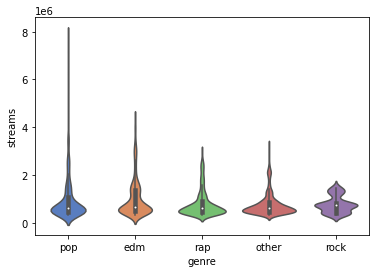

In [60]:
import seaborn as sns
ax = sns.violinplot(x='genre', y='streams', data=df, palette='muted')
#df.head()

In [ ]:

#def get_artist_genres(data):
    #artist_no_space = '+'.join(data.split())
    #trackItem = sp.search(artist_no_space, 1, 0)
    #audiofeatures = sp.audio_features(trackItem['tracks']['items'][0]['id'])
    #print(data)
    #print(audiofeatures)
    #return 1
    #return artist["genres"]
#df['artist'].apply(lambda x: get_artist_genres(x))